# 一部説明をつけています

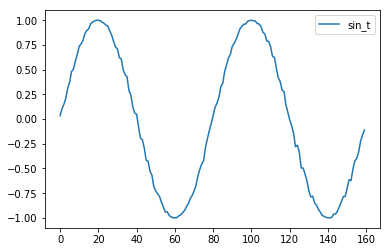

In [1]:
import pandas as pd
import numpy as np
import math
import random
%matplotlib inline
random.seed(0)
# 乱数の係数
random_factor = 0.05
# サイクルあたりのステップ数
steps_per_cycle = 80
# 生成するサイクル数
number_of_cycles = 50

df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles + 1), columns=["t"])
df["sin_t"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
df[["sin_t"]].head(steps_per_cycle * 2).plot()

In [2]:
def _load_data(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.1, n_prev = 100):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))
    ntrn = int(ntrn)
    X_train, y_train = _load_data(df.iloc[0:ntrn], n_prev)
    X_test, y_test = _load_data(df.iloc[ntrn:], n_prev)

    return (X_train, y_train), (X_test, y_test)

In [3]:
length_of_sequences = 100

(X_train, y_train), (X_test, y_test) = train_test_split(df[["sin_t"]], n_prev =length_of_sequences)  

* dataディレクトリを作成して、trainingデータをローカルに保存します

In [16]:
import os

os.makedirs("./data", exist_ok = True)

np.save('./data/X_train.npy', X_train)
np.save('./data/y_train.npy', y_train)

* ローカルに保存したtrainingデータをS3にアップロードします
* outputに保存先のS3のバケットとパスが表示されます
* S3のマネジメントコンソールで見れば、X_train.npy  y_train.npy が保存されていることが確認できるはずです

In [5]:
import sagemaker
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker_session.default_bucket()
input_data = sagemaker_session.upload_data(path='./data', bucket=bucket_name, key_prefix='dataset/keras-rnn-sin')
print('Training data is uploaded to: {}'.format(input_data))

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-748762807827


Training data is uploaded to: s3://sagemaker-us-east-1-748762807827/dataset/keras-rnn-sin


# localトレーニング
* まずはnotebookインスタンス上でトレーニングを行います
* train_instance_type = 'local' がポイントです

In [6]:
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

role = get_execution_role()

train_instance_type = 'local'

estimator = TensorFlow(
    entry_point = "./rnn-sin-sagemaker.py",
    role=role,
    train_instance_count=1,
    train_instance_type=train_instance_type,
    framework_version="1.12.0",
    py_version='py3',
    script_mode=True,
    hyperparameters={'batch-size': 600,
                     'validation_split': 0.05,
                     'epochs': 15})

estimator.fit(input_data)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-748762807827
INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-scriptmode-2019-04-25-01-23-54-128


Creating tmpikjgilxk_algo-1-6otb5_1 ... 
Attaching to tmpikjgilxk_algo-1-6otb5_1
algo-1-6otb5_1  | 2019-04-25 01:23:57,519 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-6otb5_1  | 2019-04-25 01:23:57,524 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-6otb5_1  | 2019-04-25 01:23:57,698 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-6otb5_1  | 2019-04-25 01:23:57,716 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-6otb5_1  | 2019-04-25 01:23:57,729 sagemaker-containers INFO     Invoking user script
algo-1-6otb5_1  | 
algo-1-6otb5_1  | Training Env:
algo-1-6otb5_1  | 
algo-1-6otb5_1  | {
algo-1-6otb5_1  |     "additional_framework_parameters": {},
algo-1-6otb5_1  |     "channel_input_dirs": {
algo-1-6otb5_1  |         "training": "/opt/ml/input/data/training"
algo-1-6otb5_1  |     },
algo-1-6otb5_1  |     "current_host": "algo-1-6o

# ローカル上に推論エンドポイントを作成します
* 同様に local になっているところがポイントです

In [18]:
instance_type = 'local'

predictor = estimator.deploy(instance_type=instance_type, initial_instance_count=1)

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-scriptmode-2019-04-25-01-26-06-493
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-scriptmode-2019-04-25-01-26-06-493


----------------------------------------------------------------------------!

# ローカル上の推論エンドポイントにtest用データを投げて推論してみます

In [8]:
prediction = predictor.predict(X_test)

algo-1-1wtjs_1  | 2019/04/25 01:26:05 [info] 14#14: *1 client 172.18.0.1 closed keepalive connection
algo-1-1wtjs_1  | 172.18.0.1 - - [25/Apr/2019:01:26:06 +0000] "POST /invocations HTTP/1.1" 200 3700 "-" "-"


* 推論結果をplotします

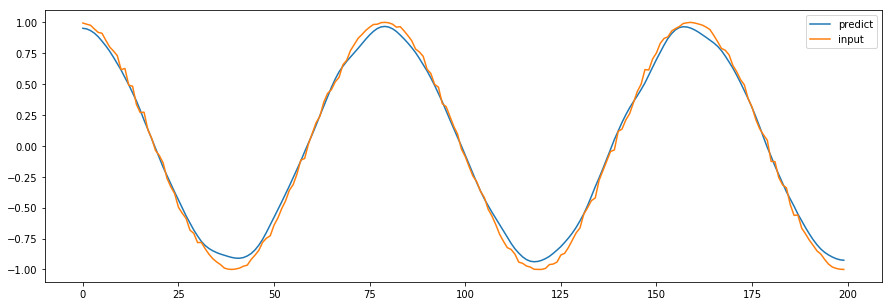

In [19]:
dataf =  pd.DataFrame(prediction['predictions'][:200])
dataf.columns = ["predict"]
dataf["input"] = y_test[:200]
dataf.plot(figsize=(15, 5))

# 以上でlocalの動作確認は終わりです。
# 次に、トレーニングジョブを実行します
* train_instance_type = 'ml.m5.large' で　MLインスタンスを選ぶと、トレーニングジョブが実行されます
* outputにトレーニングジョブ名が出力されます。
* SageMakerのマネジメントコンソールでトレーニングジョブの画面で、そのジョブ名で探すとジョブが立ち上がっているのが確認できるはず


In [20]:
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

role = get_execution_role()

train_instance_type = 'ml.m5.large'

estimator = TensorFlow(
    entry_point = "./rnn-sin-sagemaker.py",
    role=role,
    train_instance_count=1,
    train_instance_type=train_instance_type,
    framework_version="1.12.0",
    py_version='py3',
    script_mode=True,
    hyperparameters={'batch-size': 600,
                     'validation_split': 0.05,
                     'epochs': 15})

estimator.fit(input_data)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-748762807827
INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-scriptmode-2019-04-25-02-13-52-129


2019-04-25 02:13:52 Starting - Starting the training job...
2019-04-25 02:13:55 Starting - Launching requested ML instances......
2019-04-25 02:15:14 Starting - Preparing the instances for training.........
2019-04-25 02:16:40 Downloading - Downloading input data
2019-04-25 02:16:40 Training - Training image download completed. Training in progress.
2019-04-25 02:16:43,524 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-04-25 02:16:43,531 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-04-25 02:16:43,823 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-04-25 02:16:43,840 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-04-25 02:16:43,850 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "curren

* Completed - Training job completed というメッセージが表示されれば、ジョブが終わりました

# 推論エンドポイントを作成します

In [11]:
instance_type = 'ml.t2.large'

predictor = estimator.deploy(instance_type=instance_type, initial_instance_count=1)

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-scriptmode-2019-04-25-01-26-06-493
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-scriptmode-2019-04-25-01-26-06-493


-----------------------------------------------------------------------------------------!

# SageMaker上の推論エンドポイントにtest用データを投げて推論してみます

In [12]:
prediction = predictor.predict(X_test)

* 推論結果をplotする

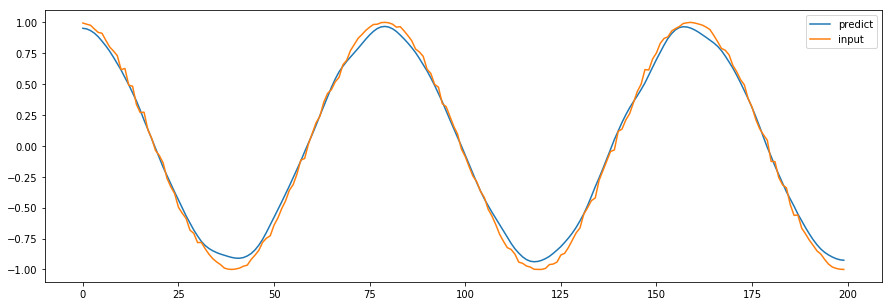

In [13]:
dataf =  pd.DataFrame(prediction['predictions'][:200])
dataf.columns = ["predict"]
dataf["input"] = y_test[:200]
dataf.plot(figsize=(15, 5))

In [14]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-tensorflow-scriptmode-2019-04-25-01-26-06-493
